Have some issues working with the HN data since the dose index are different for some plans, resulting in NaNs in data tables that complicate plotting

In [1]:
import os
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEclipseDVH import eclipse_DVH
from scipy import interpolate
from scipy import stats
from scipy.stats import wilcoxon  # must import explicitly

In [2]:
files = os.listdir()   # return a list of files
AAA_files = [file for file in files if file.endswith('AAA.txt')]
AXB_files = [file for file in files if file.endswith('Dm.txt')]

In [3]:
AXB_files

['Case10_Dm.txt',
 'Case1_Dm.txt',
 'Case2_Dm.txt',
 'Case6_Dm.txt',
 'Case8_Dm.txt',
 'Case9_Dm.txt']

In [4]:
# d = {value: foo(value) for value in sequence if bar(value)}
AAA_dict = {file.strip('.txt'): eclipse_DVH(file) for file in AAA_files}    # load all AAA DVH into dict
AXB_dict = {file.strip('.txt'): eclipse_DVH(file) for file in AXB_files}    # load all AAA DVH into dict

Case10_AAA.txt loaded 	 patID = Case10_AAA	 Prescription [Gy] = 65.010
Case1_AAA.txt loaded 	 patID = Case1_AAA	 Prescription [Gy] = 65.000
Case2_AAA.txt loaded 	 patID = Case2_AAA	 Prescription [Gy] = 65.010
Case6_AAA.txt loaded 	 patID = Case6_AAA	 Prescription [Gy] = 65.010
Case8_AAA.txt loaded 	 patID = Case8_AAA	 Prescription [Gy] = 65.010
Case9_AAA.txt loaded 	 patID = Case9_AAA	 Prescription [Gy] = 65.010
Case10_Dm.txt loaded 	 patID = Case10_Dm	 Prescription [Gy] = 65.010
Case1_Dm.txt loaded 	 patID = Case1_AXB_Dm	 Prescription [Gy] = 65.000
Case2_Dm.txt loaded 	 patID = Case2_AXB_Dm	 Prescription [Gy] = 65.010
Case6_Dm.txt loaded 	 patID = Case6_Dm	 Prescription [Gy] = 65.010
Case8_Dm.txt loaded 	 patID = Case8_Dm	 Prescription [Gy] = 65.010
Case9_Dm.txt loaded 	 patID = Case9_Dm	 Prescription [Gy] = 65.010


In [5]:
case_list = AAA_dict.keys()
case_list = [entry.strip('_AAA') for entry in case_list]
print(len(case_list))
case_list

6


['Case9', 'Case10', 'Case6', 'Case1', 'Case8', 'Case2']

In [6]:
AAA_dict['Case1_AAA'].structures_names_list

['Pseudo Other',
 'Pseudo Oral Cav',
 'Pseudo Midline',
 'PTV2 edit',
 'PTV2',
 'PTV1 edit',
 'PTV1',
 'Lt Par edit',
 'Body',
 'Annulus High',
 'Annulus Low',
 'BS + 5mm',
 'Optic Chiasm',
 'R Optic Nerve',
 'L Optic Nerve',
 'R Lens',
 'L Lens',
 'L Orbit',
 'R Orbit',
 'R Parotid',
 'L Parotid',
 'Brain Stem',
 'Spinal Cord',
 'CTV54',
 'GTV+ 10MM',
 'GTV',
 'CTV65',
 'Pseudo Post',
 'Rt Par edit',
 'SC + 3mm',
 'SC + 5mm',
 'Pseudo PTV1',
 'Pseudo PTV2',
 'Artifact Dental',
 'ArtifactContrast',
 'Dose 6175[cGy]',
 'Dose 5130[cGy]',
 'PseudoPostBrain',
 'Dummy']

## Get data

This is the only cell to edit

In [7]:
structure = 'PTV1'         # The structure to plot
#structure = 'PTV2'
xlimits = [50,75]

In [8]:
for i, key in enumerate(case_list):
    temp_AAA_DVH_df = pd.DataFrame({key : AAA_dict.get(key + '_AAA').DVH_df[structure]})       # place in a df
    temp_AXB_DVH_df = pd.DataFrame({key : AXB_dict.get(key + '_Dm').DVH_df[structure] })       # place in a df

    if i == 0:
        AAA_df = temp_AAA_DVH_df  # create the dataframe
        AXB_df  = temp_AXB_DVH_df  # create the dataframe
    else:       
        AAA_df  = pd.concat([AAA_df, temp_AAA_DVH_df], axis=1)   # if df exists, populate    
        AXB_df  = pd.concat([AXB_df, temp_AXB_DVH_df], axis=1)   # if df exists, populate
    
   # AAA_df = AAA_df.fillna(value=0)
   # AXB_df = AXB_df.fillna(value=0)
    
    AAA_df = AAA_df.fillna(method='pad')  # pad the data to fill in NaN, this is OK as difference in index is 0.01%
    AXB_df = AXB_df.fillna(method='pad')   

In [9]:
AAA_df.head()

,Case9,Case10,Case6,Case1,Case8,Case2
Dose_Gy,,,,,,
0.00000,100.0,100.0,100.0000,100.0000,100.0,100.0000
0.06500,100.0,100.0,100.0000,99.9897,100.0,100.0000
0.06501,100.0,100.0,99.9999,99.9897,100.0,100.0000
0.13000,100.0,100.0,99.9999,99.9876,100.0,100.0000
0.13002,100.0,100.0,99.9999,99.9876,100.0,99.9999


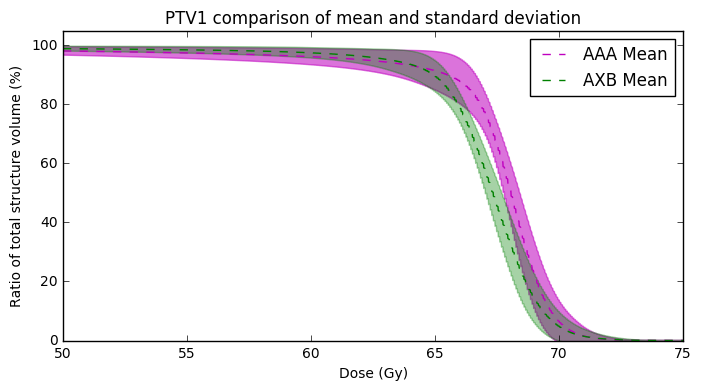

In [10]:
height=4
width=8           # wwidth of figs
plt.figure(figsize=(width, height))
    
plt.fill_between(AAA_df.mean(axis = 1).index.values, (AAA_df.mean(axis = 1) - AAA_df.std(axis = 1)).values, (AAA_df.mean(axis = 1) + AAA_df.std(axis = 1)).values, color = 'm', alpha=0.55, interpolate=True)
plt.plot(AAA_df.mean(axis = 1), color = 'm', label = 'AAA Mean', ls='--') # ls = '--', 

plt.fill_between(AXB_df.mean(axis = 1).index.values, (AXB_df.mean(axis = 1) - AXB_df.std(axis = 1)).values, (AXB_df.mean(axis = 1) + AXB_df.std(axis = 1)).values, color = 'g', alpha=0.35, interpolate=True)
plt.plot(AXB_df.mean(axis = 1), color = 'g', label = 'AXB Mean', ls='--') # ls = '--'

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend()
plt.ylim([0,105])
plt.xlim(xlimits)
plt.title(structure + ' comparison of mean and standard deviation')
plt.xlabel('Dose (Gy)')
plt.ylabel('Ratio of total structure volume (%)')

## Single case

(50, 75)

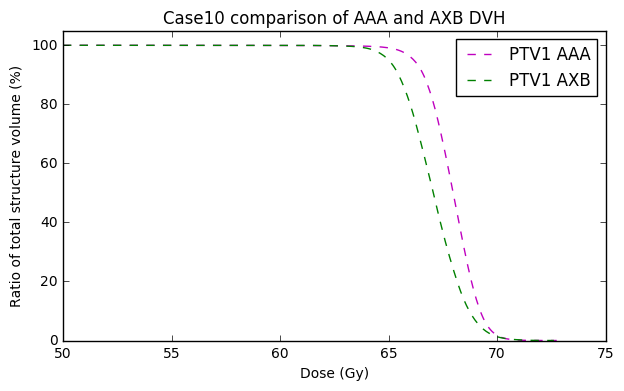

In [11]:
width=7
height=4
plt.figure(figsize=(width, height))

case = 'Case10'
structure = 'PTV1'
plt.plot(AAA_dict[case + '_AAA'].DVH_df[structure], label=structure+" AAA", color='m', ls='--')
plt.plot(AXB_dict[case +'_Dm'].DVH_df[structure], label=structure+" AXB",  color='g', ls='--' )

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend()
plt.title(case + ' comparison of AAA and AXB DVH')
plt.xlabel('Dose (Gy)')
plt.ylabel('Ratio of total structure volume (%)')
plt.ylim([0,105])
plt.xlim(xlimits)